# Titanic with TensorFlow

This tutorial demonstrates how to classify structured data, such as tabular data, using the [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview) dataset. In large parts it is based on the Tensorflow Tutorial [Classify structured data using Keras preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers).

## Import TensorFlow and other libraries


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import layers

In [2]:
tf.__version__

'2.8.0'

## Load the dataset and read it into a pandas DataFrame

<a href="https://pandas.pydata.org/" class="external">pandas</a> is a Python library with many helpful utilities for loading and working with structured data. Use `tf.keras.utils.get_file` to download and extract the CSV file:

In [3]:
dataset_url = "https://raw.githubusercontent.com/daka1510/hhz-artificial-intelligence-vl-s22/main/Exercise%20Material/Titanic%20with%20Tensorflow/train.csv"
csv_file = tf.keras.utils.get_file("train.csv", dataset_url, cache_dir=".")
dataframe = pd.read_csv(csv_file)

Inspect the dataset by checking the first five rows of the DataFrame:

In [4]:
dataframe.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Prepare data

Data preparation for this dataset was covered in depth in another notebook see [Titanic Data Preparation](https://github.com/daka1510/hhz-artificial-intelligence-vl-s22/blob/main/Exercise%20Material/Titanic/Data%20Preparation.ipynb).

In [5]:
# check for missing values
dataframe.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
# drop column 'Cabin' since there are too many missing values
dataframe = dataframe.drop(["Cabin"], axis=1)

In [7]:
# impute missing values for 'Embarked': use most frequent value
dataframe["Embarked"] = dataframe["Embarked"].fillna(
    dataframe["Embarked"].mode().iloc[0]
)

In [8]:
# impute missing values for 'Age': use mean value
dataframe["Age"] = dataframe["Age"].fillna((dataframe["Age"].mean()))

In [9]:
# verify results
dataframe.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## Split the DataFrame into training, validation, and test sets

The dataset is in a single pandas DataFrame. Split it into training, validation, and test sets using a, for example, 80:10:10 ratio, respectively:

In [10]:
train, val, test = np.split(
    dataframe.sample(frac=1), [int(0.8 * len(dataframe)), int(0.9 * len(dataframe))]
)

In [11]:
print(len(train), "training examples")
print(len(val), "validation examples")
print(len(test), "test examples")

712 training examples
89 validation examples
90 test examples


## Create an input pipeline using tf.data

Next, create a utility function that converts each training, validation, and test set DataFrame into a `tf.data.Dataset`, then shuffles and batches the data.

Note: If you were working with a very large CSV file (so large that it does not fit into memory), you would use the `tf.data` API to read it from disk directly. That is not covered in this tutorial.

In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    df = dataframe.copy()
    labels = df.pop("Survived")
    df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

Now, use the newly created function (`df_to_dataset`) to check the format of the data the input pipeline helper function returns by calling it on the training data, and use a small batch size to keep the output readable:

In [13]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

/var/folders/sb/t9mgj_gj15ldpdr9n1gdnyfh0000gn/T/ipykernel_4455/1556822771.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
2022-05-25 11:29:48.881654: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
[(train_features, label_batch)] = train_ds.take(1)
print("Every feature:", list(train_features.keys()))
print("A batch of ages:", train_features["Age"])
print("A batch of targets:", label_batch)

Every feature: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']
A batch of ages: tf.Tensor(
[[24.        ]
 [45.        ]
 [21.        ]
 [29.69911765]
 [29.69911765]], shape=(5, 1), dtype=float64)
A batch of targets: tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int64)


As the output demonstrates, the training set returns a dictionary of column names (from the DataFrame) that map to column values from rows.

## Apply the Keras preprocessing layers

The Keras preprocessing layers allow you to build Keras-native input processing pipelines, which can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and exported as part of a Keras SavedModel.

In this tutorial, you will use the following four preprocessing layers to demonstrate how to perform preprocessing, structured data encoding, and feature engineering:

- `tf.keras.layers.Normalization`: Performs feature-wise normalization of input features.
- `tf.keras.layers.CategoryEncoding`: Turns integer categorical features into one-hot, multi-hot, or <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf/" class="external">tf-idf</a>
dense representations.
- `tf.keras.layers.StringLookup`: Turns string categorical values into integer indices.
- `tf.keras.layers.IntegerLookup`: Turns integer categorical values into integer indices.

You can learn more about the available layers in the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide.

- For _numerical features_, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.
- For _categorical features_, you will transform them to multi-hot encoded tensors with `tf.keras.layers.CategoryEncoding`.

### Numerical columns

For each numeric feature, you will use a `tf.keras.layers.Normalization` layer to standardize the distribution of the data.

Define a new utility function that returns a layer which applies feature-wise normalization to numerical features using that Keras preprocessing layer:

In [15]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

Next, test the new function by calling it on the age feature to normalize `'Age'`:

In [16]:
age_col = train_features["Age"]
layer = get_normalization_layer("Age", train_ds)
layer(age_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.439553  ],
       [ 1.2059124 ],
       [-0.67461944],
       [ 0.00700418],
       [ 0.00700418]], dtype=float32)>

Note: If you have many numeric features (hundreds, or more), it is more efficient to concatenate them first and use a single `tf.keras.layers.Normalization` layer.

### Categorical columns

The `Sex` and `Embarked` columns in the dataset are represented as strings which need to be multi-hot encoded before being fed into the model.

Define another new utility function that returns a layer which maps values from a vocabulary to integer indices and multi-hot encodes the features using the `tf.keras.layers.StringLookup`, `tf.keras.layers.IntegerLookup`, and `tf.keras.CategoryEncoding` preprocessing layers:

In [17]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == "string":
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))

Test the `get_category_encoding_layer` function by calling it on `'Embarked'` features to turn them into multi-hot encoded tensors:

In [18]:
test_type_col = train_features["Embarked"]
test_type_layer = get_category_encoding_layer(
    name="Embarked", dataset=train_ds, dtype="string"
)
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)>

Repeat the process on the `'Sex'` column

In [19]:
test_type_col = train_features["Sex"]
test_type_layer = get_category_encoding_layer(
    name="Sex", dataset=train_ds, dtype="string"
)
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

## Preprocess selected features to train the model on

You have learned how to use several types of Keras preprocessing layers. Next, you will:

- Apply the preprocessing utility functions defined earlier
- Add all the feature inputs to a list.

Note: If your aim is to build an accurate model, try a larger dataset of your own, and think carefully about which features are the most meaningful to include, and how they should be represented.

Earlier, you used a small batch size to demonstrate the input pipeline. Let's now create a new input pipeline with a larger batch size of 256:

In [20]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/var/folders/sb/t9mgj_gj15ldpdr9n1gdnyfh0000gn/T/ipykernel_4455/1556822771.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
/var/folders/sb/t9mgj_gj15ldpdr9n1gdnyfh0000gn/T/ipykernel_4455/1556822771.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()}
/var/folders/sb/t9mgj_gj15ldpdr9n1gdnyfh0000gn/T/ipykernel_4455/1556822771.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:, tf.newaxis] for key, value in dataframe.items()

Normalize the numerical features, and add them to one list of inputs called `encoded_features`:

In [21]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ["Age", "SibSp", "Parch", "Fare"]:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

Turn the integer categorical values from the dataset into integer indices, perform multi-hot encoding, and add the resulting feature inputs to `encoded_features`:

In [22]:
pclass_col = tf.keras.Input(shape=(1,), name="Pclass", dtype="int64")

encoding_layer = get_category_encoding_layer(
    name="Pclass", dataset=train_ds, dtype="int64", max_tokens=5
)
encoded_pclass_col = encoding_layer(pclass_col)
all_inputs.append(pclass_col)
encoded_features.append(encoded_pclass_col)

Repeat the same step for the string categorical values:

In [23]:
categorical_cols = ["Sex", "Embarked"]

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype="string")
    encoding_layer = get_category_encoding_layer(
        name=header, dataset=train_ds, dtype="string", max_tokens=5
    )
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

## Create, compile, and train the model


The next step is to create a model using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). For the first layer in your model, merge the list of feature inputs—`encoded_features`—into one vector via concatenation with `tf.keras.layers.concatenate`.

In [24]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)

output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(all_inputs, output)

Configure the model with Keras `Model.compile`:

In [25]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Pclass (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Sex (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 Embarked (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Age (InputLayer)               [(None, 1)]          0           []                               
                                                                                              

Optional: Let's visualize the connectivity graph (requires pyplot and graphviz to be installed). See [model.png](https://github.com/daka1510/hhz-artificial-intelligence-vl-s22/blob/main/Exercise%20Material/Titanic%20with%20Tensorflow/model.png) for an example.


In [27]:
# Use `rankdir='LR'` to make the graph horizontal.
# tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

Next, train and test the model:

In [28]:
history = model.fit(train_ds, epochs=50, validation_data=val_ds)  # verbose

Epoch 1/50


/Users/ellenhoeven/opt/anaconda3/envs/hhz-py38/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['PassengerId', 'Survived', 'Name', 'Ticket'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)
/Users/ellenhoeven/opt/anaconda3/envs/hhz-py38/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 1s 128ms/step - loss: 0.7279 - accuracy: 0.3806 - val_loss: 0.7321 - val_accuracy: 0.2809
Epoch 2/50
3/3 [==============================] - 0s 13ms/step - loss: 0.7148 - accuracy: 0.3876 - val_loss: 0.7224 - val_accuracy: 0.3034
Epoch 3/50
3/3 [==============================] - 0s 12ms/step - loss: 0.7016 - accuracy: 0.4185 - val_loss: 0.7133 - val_accuracy: 0.4045
Epoch 4/50
3/3 [==============================] - 0s 12ms/step - loss: 0.6896 - accuracy: 0.5056 - val_loss: 0.7045 - val_accuracy: 0.4944
Epoch 5/50
3/3 [==============================] - 0s 12ms/step - loss: 0.6777 - accuracy: 0.6039 - val_loss: 0.6963 - val_accuracy: 0.5618
Epoch 6/50
3/3 [==============================] - 0s 14ms/step - loss: 0.6664 - accuracy: 0.6615 - val_loss: 0.6882 - val_accuracy: 0.5955
Epoch 7/50
3/3 [==============================] - 0s 13ms/step - loss: 0.6554 - accuracy: 0.6994 - val_loss: 0.6803 - val_accuracy: 0.6067
Epoch 8/50
3/3 [=====================

In [29]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

1/1 [==============================] - 0s 18ms/step - loss: 0.4203 - accuracy: 0.8333
Accuracy 0.8333333134651184


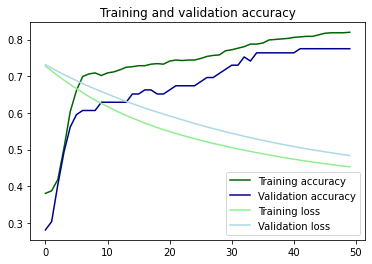

<Figure size 432x288 with 0 Axes>

In [30]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "darkgreen", label="Training accuracy")
plt.plot(epochs, val_acc, "darkblue", label="Validation accuracy")
plt.plot(epochs, loss, "lightgreen", label="Training loss")
plt.plot(epochs, val_loss, "lightblue", label="Validation loss")
plt.title("Training and validation accuracy")
plt.legend(loc=0)
plt.figure()


plt.show()


## Evaluate Model (Confusion Matrix)

In [31]:
y_pred = model.predict(test_ds)

In [32]:
predicted_categories = tf.round(y_pred)

In [33]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)


In [34]:
true_categories

<tf.Tensor: shape=(90,), dtype=int64, numpy=
array([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1])>

In [35]:
# yields count of true negatives, false positives, false negatives, true positives
confusion_matrix(predicted_categories, true_categories)

array([[51,  9],
       [ 6, 24]])

In [36]:
# check that tp, fp, tn, fn are not confused
tn, fp, fn, tp = confusion_matrix(true_categories, predicted_categories).ravel()
print(tn, fp, fn, tp)

51 6 9 24


In [37]:
# yields class-specific precision, recall and f1-score
print(classification_report(true_categories, predicted_categories)) 

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        57
           1       0.80      0.73      0.76        33

    accuracy                           0.83        90
   macro avg       0.82      0.81      0.82        90
weighted avg       0.83      0.83      0.83        90



## Perform inference

The model you have developed can now classify a row from a CSV file directly after you've included the preprocessing layers inside the model itself.

You can now [save and reload the Keras model](../keras/save_and_load.ipynb) with `Model.save` and `Model.load_model` before performing inference on new data:

In [38]:
model.save("titanic_classifier/1")
reloaded_model = tf.keras.models.load_model("titanic_classifier/1")

2022-05-25 11:29:56.893547: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: titanic_classifier/1/assets


INFO:tensorflow:Assets written to: titanic_classifier/1/assets


In [39]:
# model.save("/Users/ellenhoeven/hhz-artificial-intelligence-vl-s22/Exercise Material/Titanic with Tensorflow/titanic_classifier/v1", save_format="tf")

To get a prediction for a new sample, you can simply call the Keras `Model.predict` method. There are just two things you need to do:

1.   Wrap scalars into a list so as to have a batch dimension (`Model`s only process batches of data, not single samples).
2.   Call `tf.convert_to_tensor` on each feature.

In [40]:
dataframe.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,S


In [41]:
sample = {
    "PassengerId": 231,
    "Pclass": 3,
    "Name": "Braund, Mr. Owen Harris",
    "Sex": "male",
    "Age": 22.0,
    "SibSp": 1,
    "Parch": 0,
    "Ticket": "A/5 21171",
    "Fare": 7.25,
    "Embarked": "S",
}
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
prob = reloaded_model.predict(input_dict)[0]
print(
    "This particular passenger had a %.1f percent probability "
    "of surviving." % (100 * prob)
)

This particular passenger had a 17.9 percent probability of surviving.


/Users/ellenhoeven/opt/anaconda3/envs/hhz-py38/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['PassengerId', 'Name', 'Ticket'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Note: You will typically have better results with deep learning with larger and more complex datasets. When working with a small dataset, simpler algorithms (e.g. decision tree, logistic regression) often provide a strong baseline.

# Docker Deployment

You will use [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/docker) to serve your model with the aid of a Docker container. Requires a local [docker](https://www.docker.com/) installation. To try it out, run below commands in a Terminal (and replace local paths as needed):


    
    docker run -t --rm -p 8501:8501 \
    -v "/Users/ellenhoeven/hhz-artificial-intelligence-vl-s22/Exercise Material/Titanic with Tensorflow/titanic_classifier:/models/titanic_classifier" \
    -e MODEL_NAME=titanic_classifier \
    tensorflow/serving

```bash
# 1 Download the TensorFlow Serving Docker image
docker pull tensorflow/serving

# 2 Start TensorFlow Serving container and open the REST API port
docker run -t --rm -p 8501:8501 \
    -v "/Users/danielkaulen/Development/hhz-artificial-intelligence-vl-s22/Exercise Material/Titanic with Tensorflow/titanic_classifier:/models/titanic_classifier" \
    -e MODEL_NAME=titanic_classifier \
    tensorflow/serving

# 3 Check model metadata
curl http://localhost:8501/v1/models/titanic_classifier/metadata

# 4 Perform inference via the REST API (using the supported subset of features)
curl -d '{"instances": [{"Pclass":[3],"Sex":["male"],"Age":[22.0],"SibSp":[1],"Parch":[0],"Fare":[7.25],"Embarked":["S"]}]}' -X POST http://localhost:8501/v1/models/titanic_classifier:predict

# 5 Get list of running containers 
docker ps

# 6 Stop running container forcefully
docker rm -f <id>
```